# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Check GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(1))

2
NVIDIA GeForce RTX 3090


# Part A

## Implement Custom Resnet

In [3]:
class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()

        # Initial layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Residual block 1
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # 1x1 convolution for matching dimensions in the first residual connection
        self.match_conv1 = nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0)

        # Residual block 2
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 1x1 convolution for matching dimensions in the second residual connection
        self.match_conv2 = nn.Conv2d(64, 128, kernel_size=1, stride=2, padding=0)

        # Residual block 3
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        # 1x1 convolution for matching dimensions in the third residual connection
        self.match_conv3 = nn.Conv2d(128, 256, kernel_size=1, stride=2, padding=0)

        # Final layers
        self.avg_pool = nn.AvgPool2d(kernel_size=3)
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = self.pool1(x)

        # Residual block 1
        identity = x
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x += identity
        x = F.elu(x)

        # Residual block 2
        identity = self.match_conv2(x)  # Adjust dimensions of identity
        x = F.elu(self.conv5(x))
        x = self.pool2(x)
        x += identity
        x = F.elu(x)

        # Residual block 3
        identity = self.match_conv3(x)  # Adjust dimensions of identity
        x = F.elu(self.conv6(x))
        x = self.pool3(x)
        x = F.elu(self.conv7(x))
        x += identity
        x = F.elu(x)

        # Final layers
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)

        return x


## Load Dataset

In [4]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# # Data augmentation and normalization for training
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Optimizer and Train Setup

In [6]:
# Model, optimizer, and scheduler
model = CustomResNet()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [7]:
# Determine if CUDA is available and set the device accordingly
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (match_conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (match_conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (match_conv3): Conv2d(128, 256, kernel_size=(1, 

In [8]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# Training loop with tracking of training and validation accuracies
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
best_val_accuracy = 0
best_model_weights = None


In [9]:
for epoch in range(1, 61):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer , criterion)
    val_loss, val_accuracy = test(model, device, val_loader , criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    scheduler.step()

Epoch: 1, Train Loss: 2.1089, Train Accuracy: 21.68%, Val Loss: 1.9392, Val Accuracy: 28.36%
Epoch: 2, Train Loss: 1.7734, Train Accuracy: 34.53%, Val Loss: 1.6428, Val Accuracy: 38.52%
Epoch: 3, Train Loss: 1.5618, Train Accuracy: 42.22%, Val Loss: 1.4984, Val Accuracy: 44.12%
Epoch: 4, Train Loss: 1.4264, Train Accuracy: 47.76%, Val Loss: 1.3946, Val Accuracy: 49.36%
Epoch: 5, Train Loss: 1.3043, Train Accuracy: 52.74%, Val Loss: 1.2759, Val Accuracy: 54.36%
Epoch: 6, Train Loss: 1.1781, Train Accuracy: 57.66%, Val Loss: 1.1801, Val Accuracy: 57.14%
Epoch: 7, Train Loss: 1.0819, Train Accuracy: 61.16%, Val Loss: 1.1244, Val Accuracy: 60.26%
Epoch: 8, Train Loss: 0.9918, Train Accuracy: 64.95%, Val Loss: 0.9821, Val Accuracy: 64.56%
Epoch: 9, Train Loss: 0.9162, Train Accuracy: 67.58%, Val Loss: 0.9170, Val Accuracy: 67.64%
Epoch: 10, Train Loss: 0.8494, Train Accuracy: 69.94%, Val Loss: 0.8746, Val Accuracy: 68.54%
Epoch: 11, Train Loss: 0.8019, Train Accuracy: 71.70%, Val Loss: 0.83

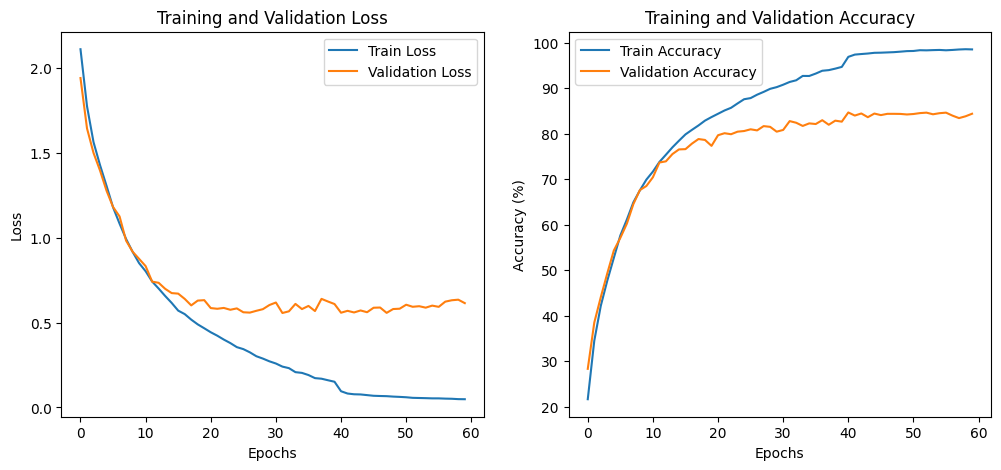

Best Validation Accuracy: 84.70%
Test Accuracy of the final model: 85.37%


In [10]:
# Load best model weights and evaluate on test set
model.load_state_dict(best_model_weights)
test_loss, test_accuracy = test(model, device, test_loader , criterion)

# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Print best validation accuracy and test accuracy
print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')
print(f'Test Accuracy of the final model: {test_accuracy:.2f}%')

# Save best model weights
torch.save(best_model_weights, 'best_custom_resnet_weights.pth')

# Layer Wise analyse

In [ ]:
# download Pretrained Weight of model
import gdown
id = "1Rt9NDT6pjEqY_-wecU0WZFEfnxVxFxw2"
gdown.download(id=id, quiet=False)

In [ ]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

In [2]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

In [3]:
class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()

        # Initial layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Residual block 1
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # 1x1 convolution for matching dimensions in the first residual connection
        self.match_conv1 = nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0)

        # Residual block 2
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 1x1 convolution for matching dimensions in the second residual connection
        self.match_conv2 = nn.Conv2d(64, 128, kernel_size=1, stride=2, padding=0)

        # Residual block 3
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        # 1x1 convolution for matching dimensions in the third residual connection
        self.match_conv3 = nn.Conv2d(128, 256, kernel_size=1, stride=2, padding=0)

        # Final layers
        self.avg_pool = nn.AvgPool2d(kernel_size=3)
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = self.pool1(x)

        # Residual block 1
        identity = x
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x += identity
        x = F.elu(x)

        # Residual block 2
        identity = self.match_conv2(x)  # Adjust dimensions of identity
        x = F.elu(self.conv5(x))
        x = self.pool2(x)
        x += identity
        x = F.elu(x)

        # Residual block 3
        identity = self.match_conv3(x)  # Adjust dimensions of identity
        x = F.elu(self.conv6(x))
        x = self.pool3(x)
        x = F.elu(self.conv7(x))
        x += identity
        x = F.elu(x)

        # Final layers
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)

        return x


In [4]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# Further split train_dataset into train_loader_dataset and 20% balanced subset
train_loader_dataset, _ = train_test_split(train_dataset.dataset, train_size=int(0.2 * len(train_dataset)),
                                           test_size=None, shuffle=True, stratify=train_dataset.dataset.targets)

# Data loaders
train_loader = DataLoader(train_loader_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Instantiate and load the model
model = CustomResNet()  # Make sure CustomResNet is defined as earlier
model.load_state_dict(torch.load('best_custom_resnet_weights.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

CustomResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (match_conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (match_conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (match_conv3): Conv2d(128, 256, kernel_size=(1, 

In [7]:
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'match_conv1', 'match_conv2', 'match_conv3', 'fc1', 'fc2'}

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

## SI and CenterSI layer for Train Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 36/36 [00:00<00:00, 65.53it/s]


### Calc SI

In [10]:
si_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_train.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7121.06it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7527.47it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7063.50it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7653.84it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7211.66it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7524.76it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7961.85it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7423.55it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6964.97it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7943.76it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7246.55it/s]


In [11]:
si_layer_train

[('conv1', 0.23422221839427948),
 ('conv2', 0.2204444408416748),
 ('pool1', 0.32677778601646423),
 ('conv3', 0.37533333897590637),
 ('conv4', 0.410444438457489),
 ('conv5', 0.4432222247123718),
 ('pool2', 0.46622222661972046),
 ('conv6', 0.5736666917800903),
 ('pool3', 0.5591111183166504),
 ('conv7', 0.6612222194671631),
 ('avg_pool', 0.7605555653572083)]

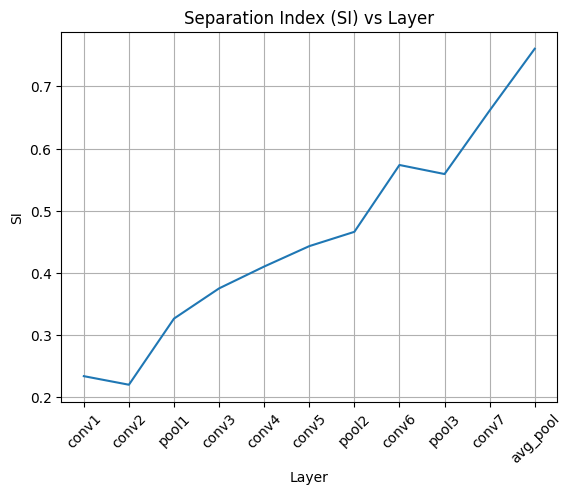

In [12]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_train], [si for _, si in si_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center Si

In [13]:
csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 766.70it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3843.75it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3059.75it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3002.79it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3450.97it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4766.25it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3733.58it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3457.79it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4274.67it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4470.59it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2863.01it/s]


[('conv1', 0.3466666638851166), ('conv2', 0.3377777934074402), ('pool1', 0.42266666889190674), ('conv3', 0.5024444460868835), ('conv4', 0.5377777814865112), ('conv5', 0.5376666784286499), ('pool2', 0.5678889155387878), ('conv6', 0.5743333101272583), ('pool3', 0.6573333144187927), ('conv7', 0.6758888959884644), ('avg_pool', 0.7904444336891174)]


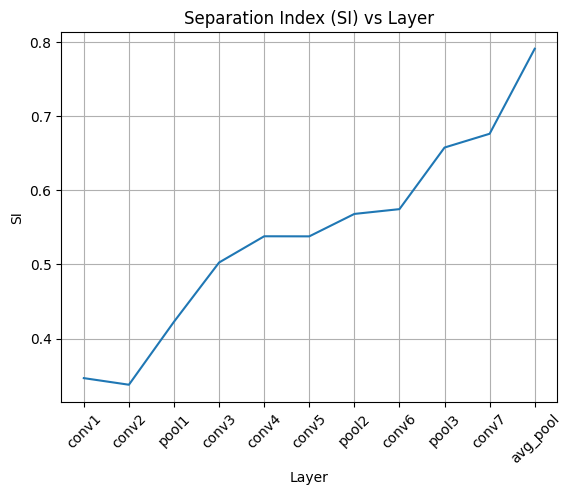

In [14]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Val Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(val_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 20/20 [00:00<00:00, 21.66it/s]


### Calc SI

In [9]:
si_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_val.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 187.88it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5115.00it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5112.93it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4716.23it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5313.73it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5184.55it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5300.30it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5511.57it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5381.91it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5059.47it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4410.41it/s]


In [10]:
si_layer_val

[('conv1', 0.2207999974489212),
 ('conv2', 0.20559999346733093),
 ('pool1', 0.3046000003814697),
 ('conv3', 0.337799996137619),
 ('conv4', 0.3837999999523163),
 ('conv5', 0.4107999801635742),
 ('pool2', 0.438400000333786),
 ('conv6', 0.5473999977111816),
 ('pool3', 0.5363999605178833),
 ('conv7', 0.6439999938011169),
 ('avg_pool', 0.7495999932289124)]

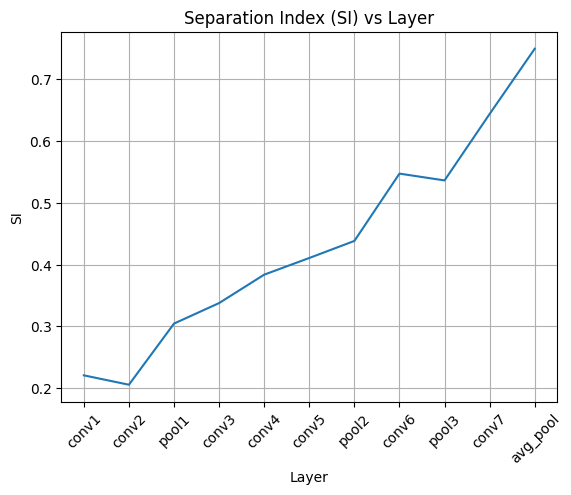

In [11]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_val], [si for _, si in si_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### calc Center SI

In [12]:
csi_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_val.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 419.05it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3148.09it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3026.92it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3131.64it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3758.34it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3199.32it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3187.16it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3212.38it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3038.62it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3226.39it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2243.34it/s]


[('conv1', 0.37299999594688416), ('conv2', 0.35499998927116394), ('pool1', 0.4389999806880951), ('conv3', 0.5381999611854553), ('conv4', 0.5600000023841858), ('conv5', 0.5636000037193298), ('pool2', 0.5911999940872192), ('conv6', 0.5929999947547913), ('pool3', 0.6807999610900879), ('conv7', 0.6901999711990356), ('avg_pool', 0.8029999732971191)]


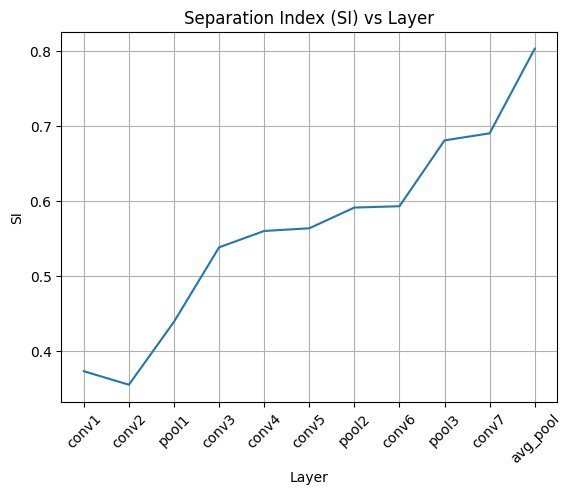

In [13]:
print(csi_layer_val)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_val], [si for _, si in csi_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Test Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 40/40 [00:01<00:00, 26.22it/s]


### Calc SI

In [9]:
si_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_test.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 362.36it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7637.12it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7350.69it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6811.15it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7013.89it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7778.75it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7992.20it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7241.55it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7778.75it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7653.84it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6923.58it/s]


In [10]:
si_layer_test

[('conv1', 0.22809998691082),
 ('conv2', 0.22280000150203705),
 ('pool1', 0.313400000333786),
 ('conv3', 0.3652999997138977),
 ('conv4', 0.4047999978065491),
 ('conv5', 0.44279998540878296),
 ('pool2', 0.4585999846458435),
 ('conv6', 0.564300000667572),
 ('pool3', 0.5587999820709229),
 ('conv7', 0.6434000134468079),
 ('avg_pool', 0.7005999684333801)]

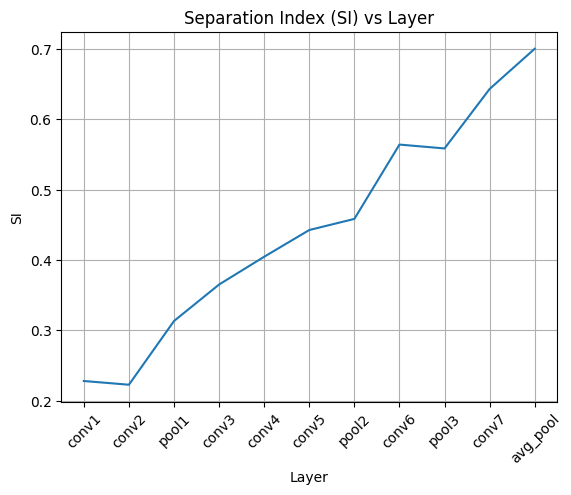

In [11]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_test], [si for _, si in si_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center SI

In [12]:
csi_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_test.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 934.85it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4328.49it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3286.56it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3380.32it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3122.62it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4274.67it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4185.10it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3287.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4073.72it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4307.15it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4228.13it/s]


[('conv1', 0.3538999855518341), ('conv2', 0.3458999991416931), ('pool1', 0.4262000024318695), ('conv3', 0.5036999583244324), ('conv4', 0.5385000109672546), ('conv5', 0.5317000150680542), ('pool2', 0.5638999938964844), ('conv6', 0.5672999620437622), ('pool3', 0.6410999894142151), ('conv7', 0.6574999690055847), ('avg_pool', 0.7324999570846558)]


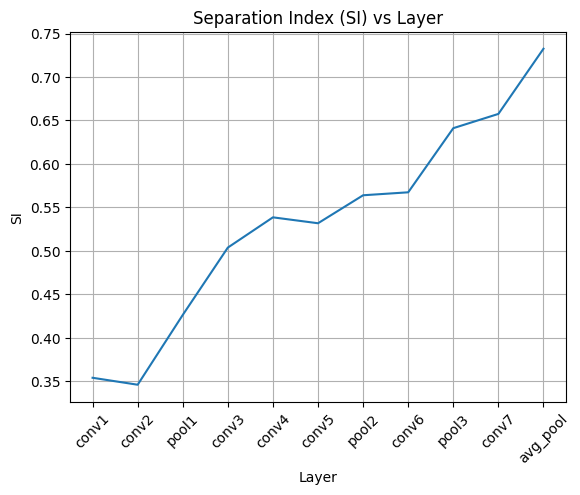

In [13]:
print(csi_layer_test)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_test], [si for _, si in csi_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()